# Foundations of AI & ML
## Session 10
### Experiment 4
#### RNNs for financial forecasting

In this experiment, we will be using stock market dataset. The dataset contains historical daily price and volume data for all US-based stocks and E
TFs trading on the NYSE, NASDAQ, and NYSE MKT.

In [2]:
# The below are wrapper functions used to connect to your drive and this needs to be run once (i.e. once every new session or possibily refreshes for every 24 hours)

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Authentication for your google drive
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

# Authentication for the wrapper libraries  or possibily refreshes for every 24 hours)

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpp7ldlyz5/pubring.gpg' created
gpg: /tmp/tmpp7ldlyz5/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p MyDrive

In [0]:
!google-drive-ocamlfuse MyDrive

In [12]:
%cd ../

/content/MyDrive


In [8]:
!ls

1519994626334jYyPtTUkzhp69j3M.xls
1519994626334jYyPtTUkzhp69j3M.xls.ods
15199947123589olwgYdAjDtq8hjk.xls
15199947123589olwgYdAjDtq8hjk.xls.ods
20k Media - Journalist, Magazines, Radio, TV, Newspaper.ods
20k Media List - Journalist, Magazines, Radio, TV, Newspaper.ods
3rd- Semester-Jayanth.ods
3rd- Semester-Jayanth.ods (1d9862ed)
5 Startup Attack Plan.odt
AcadGild Master Service Agreement-Jayanth Rasamsetti (1).pdf
Activity
Addressing Gaps & Issues - Being on the same page.odt
Affidavit of Client re Extension of Status.odt
AI Apollo Proposal.odt
AIML Glossary.odt
AI.odt
Akash CA.ods
Angel.co Jay.xlsx
Angel.co Jay.xlsx.ods
Angel.co Jay.xlsx.ods (d9a58534)
Anisetti_Vijaya_Intl_Student_Financial_Profile.pdf
Anon chat plan.odt
Application 2013.odt
attachments (1).zip
Aug'14 India trip
Authorised Signatory (2).rtf
Authorised Signatory (2).rtf.odt
Big Data & Data Science.odt
Board Resolution GST.odt
Board Resolution.odt
Brokers.ods
Case Study Team 10 (2).pdf
Colab Notebooks
config.py
Consult

In [13]:
%cd Session-10

/content/MyDrive/Session-10


#### Importing Packages

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
### importing pytorch packages
import torch
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

#### Loading the directory

In [17]:
import os
##Loading the data folder
print(os.listdir("./Data"))

['ETFs', 'Stocks']


#### Creating a model to load the stock data

In [0]:
class StockDataset(Dataset):

    def __init__(self, x_data_to_process, y_data_to_process):
        """ inputs for x and y values are given as pandas obj """
        self.data = pd.merge(x_data_to_process, y_data_to_process, on='Date')
        self.data = self.data.values    # from pd to np

        print('The shape of the data is {}'.format(self.data.shape))

        self.x_data = self.data[:, 1:x_data_to_process.shape[1]].astype(np.float32)
        self.y_data = self.data[:, x_data_to_process.shape[1]:].astype(np.float32)

        """ Normalize x_data, putting it off for now """
        self.rebase_to_one()

        """ convert to torch """
        self.x_data = torch.from_numpy(self.x_data)
        self.y_data = torch.from_numpy(self.y_data)

        self.len = self.data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

    def rebase_to_one(self):
        """ self.x_data rebased to one on the firsts element """
        self.x_data = self.x_data.T
        list_of_first_elem_price = [i[0] for i in self.x_data]
        shape_row, shape_column = self.x_data.shape[0], self.x_data.shape[1]

        for i in range(shape_row):
            for j in range(shape_column):
                self.x_data[i][j] /= list_of_first_elem_price[i]
        self.x_data = self.x_data.T


# We load the stock data from the dataset folder.
def get_dictionary_of_data():
    def get_dictionary_of_data_helper(list_of_stocks):
        dict_of_stocks = {}
        for i in range(len(list_of_stocks)):
            key = str(list_of_stocks[i]).lower()
            path ='./Data/Stocks/{}.us.txt'.format(key)
            try:
                dict_of_stocks[key] = pd.read_csv(path)
            except IOError:
                print("File of {} not found".format(key))

        return dict_of_stocks

    # Use these tickers if possible to predict S&P's value
    spx_partial_list = np.array(['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO',
                                     'KO', 'DWDP', 'XOM', 'GE', 'GS', 'HD', 'IBM', 'INTC',
                                     'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG',
                                     'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WMT', 'DIS'])

    return get_dictionary_of_data_helper(spx_partial_list)

### we are collecting closing price data 
def closing_prices_in_pd(dict_of_stocks):
    """ merge stock data on Dates """
    temp_dict = {}
    for i in dict_of_stocks.keys():
        temp_dict[i] = (dict_of_stocks[i])[['Date', 'Close', 'Volume']]

    merged = None
    for i in temp_dict.keys():
        if merged is None:
            merged = temp_dict[i]
        elif temp_dict[i].shape[0] > 3000: # Arbitrary selection, longer than 3000
            merged = pd.merge(merged, temp_dict[i], on='Date')

    return merged

#### Let us build a rnn model

In [0]:
class Model(torch.nn.Module):

    def __init__(self, input_size, rnn_hidden_size, output_size):

        super(Model, self).__init__()

        self.rnn = torch.nn.RNN(1, rnn_hidden_size,
                                num_layers=2, nonlinearity='relu',
                                batch_first=True)
        self.h_0 = self.initialize_hidden(rnn_hidden_size)

        self.linear = torch.nn.Linear(rnn_hidden_size, output_size)
    ### Forward Pass
    def forward(self, x):
        self.rnn.flatten_parameters()
        #print(x.size())
        x, _ = self.rnn(x)
        x = x[:,:,-1]
        #print(x.size())
        out = self.linear(x)
        #print(out.size())
        return out

    def initialize_hidden(self, rnn_hidden_size):
        # n_layers * n_directions, batch_size, rnn_hidden_size
        return Variable(torch.randn(2, 1, rnn_hidden_size),
                        requires_grad=True)

#### Defining a train function

In [0]:
RNN_HIDDEN_SIZE = 24


def train(input_size, hidden_size, output_size, train_loader):
    plt.figure(1, figsize=(12, 5))

    file_path = 'my_model.model'

    try:
        model = torch.load(file_path)
    except:
        model = Model(input_size, hidden_size, output_size)
    ## Defining loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 25

    for epoch in range(epochs):
        predictions = []
        correct_values = []

        for i, data in enumerate(train_loader):
            xs, ys = data
            
            ## Converting xs,ys into tourch variables
            xs, ys = Variable(xs), Variable(ys)
            #print(xs.shape)
            xs = torch.unsqueeze(xs,2)
            #print(xs.shape)
            ## predicting the values
            y_pred = model(xs)
            ## Calculating the loss
            loss = criterion(y_pred, ys)
            optimizer.zero_grad()
            ## Backward Pass
            loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
            optimizer.step()
            ### Storing the predicted values into list in form of numpy array
            predictions.append(y_pred.cpu().data.numpy().ravel())
            correct_values.append(ys.cpu().data.numpy().ravel())
            
        def stacking_for_charting(given_list):
            ret = np.array([0])
            for i in given_list:
                ret = np.hstack((ret, i.ravel()))
            return ret[1:]
        ## Stacking the predictions values
        predictions_for_chart = stacking_for_charting(predictions)
        correct_values_for_chart = stacking_for_charting(correct_values)

        print(predictions_for_chart)

        steps = np.linspace(epoch*predictions_for_chart.shape[0],
                            (epoch+1)*predictions_for_chart.shape[0],
                            predictions_for_chart.shape[0])
        ## plotting the predicted values
        plt.plot(steps, predictions_for_chart, 'r-')
        ##plotting the original values
        plt.plot(steps, correct_values_for_chart, 'b-')
        plt.draw()
        plt.pause(0.05)

    torch.save(model, file_path)
    plt.show()

#### Function to load the dataset

In [0]:
def main():

    """ getting dictionary of stock data ETFs"""
    X_data_source = get_dictionary_of_data()

    """ etf data is used as Y variable"""
    Y_data_source = {'spy': pd.read_csv('./Data/ETFs/spy.us.txt')}

    X_data = closing_prices_in_pd(X_data_source)
    Y_data = closing_prices_in_pd(Y_data_source)
    
    #print(X_data.shape,Y_data.shape)

    Y_data = Y_data.drop(['Volume'], axis=1)

    dataset = StockDataset(X_data, Y_data)
    ## Loading the dataset
    train_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=False, num_workers=1)

    input_size = X_data.shape[1]-1
    hidden_size = RNN_HIDDEN_SIZE
    output_size = Y_data.shape[1]-1
    ## training the model
    train(input_size, hidden_size, output_size, train_loader)

File of mmm not found
File of axp not found
File of cat not found
File of ko not found
File of ge not found
File of gs not found
File of hd not found
File of ibm not found
File of intc not found
File of jnj not found
File of mrk not found
File of pg not found
File of trv not found
File of unh not found
File of utx not found
File of v not found
File of wmt not found
File of dis not found
The shape of the data is (3200, 26)
[ 75.27335358  75.09746552  74.82011414 ... 300.08041382 299.60498047
 298.79925537]


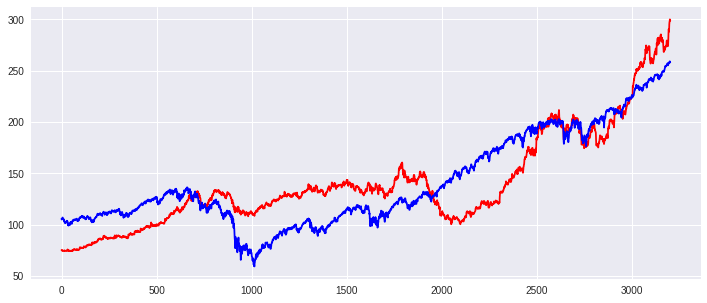

[ 80.82870483  80.58929443  80.30653381 ... 246.57565308 246.17462158
 245.5559845 ]


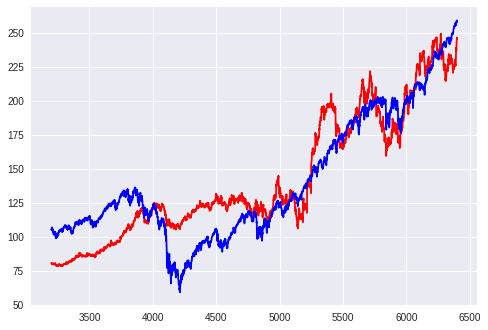

[ 69.46713257  69.70243073  69.68348694 ... 273.62210083 273.18002319
 272.48770142]


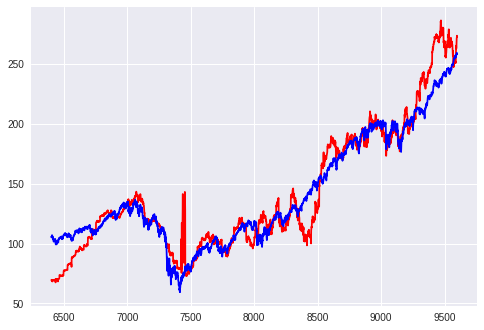

[ 73.64277649  73.6627121   73.56732178 ... 262.4303894  262.00918579
 261.35137939]


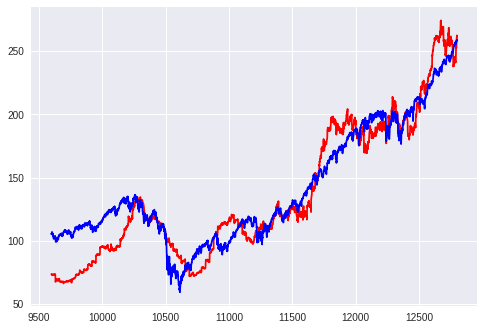

[ 76.09174347  76.14604187  76.05540466 ... 260.24078369 259.37612915
 260.11526489]


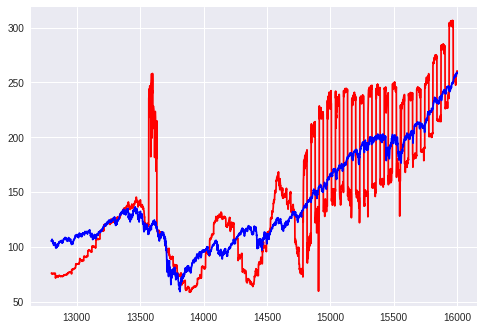

[125.91135406 126.31119537 127.14870453 ... 263.14056396 262.7043457
 262.05673218]


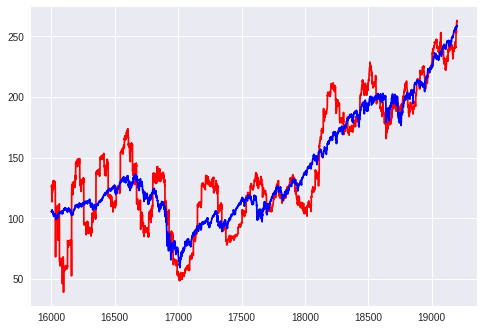

[ 72.20944214  72.07688904  72.02233124 ... 284.29516602 283.87539673
 283.01565552]


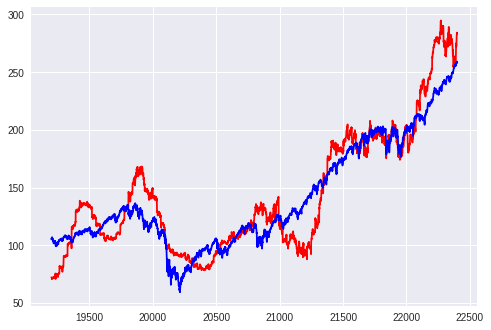

[ 69.06640625  68.92454529  68.68586731 ... 303.8762207  303.39154053
 302.62902832]


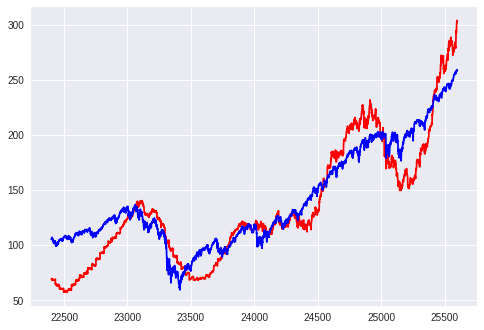

[ 90.29699707  90.31651306  90.21108246 ... 295.14355469 294.67156982
 293.91229248]


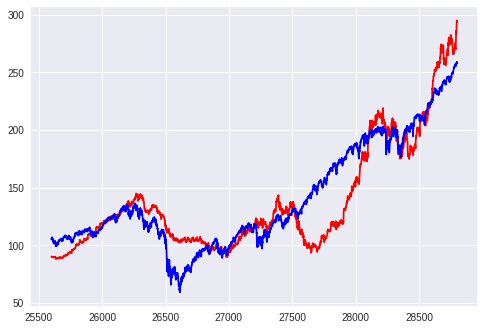

[ 82.54064178  82.4834137   82.32946777 ... 292.46456909 292.00561523
 291.22839355]


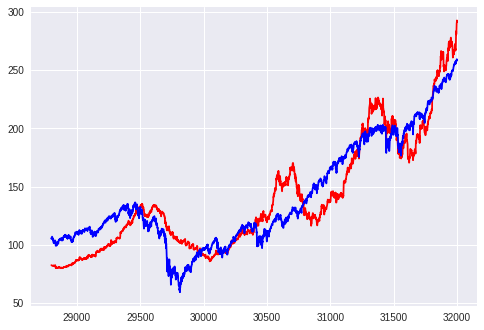

[ 79.10499573  78.9631958   78.76166534 ... 327.07644653 326.55813599
 325.68579102]


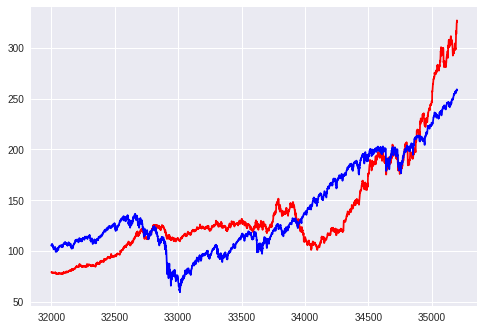

[ 88.5521698   88.38679504  88.12245941 ... 308.35293579 307.86593628
 307.0475769 ]


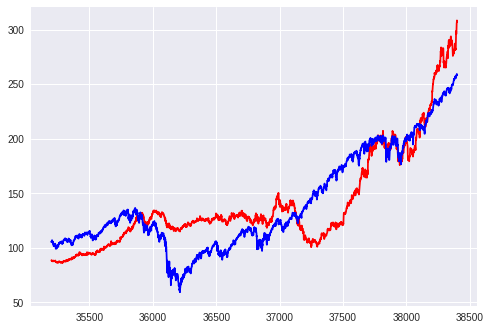

[ 86.20837402  86.00886536  85.77450562 ... 309.98043823 309.49777222
 308.68743896]


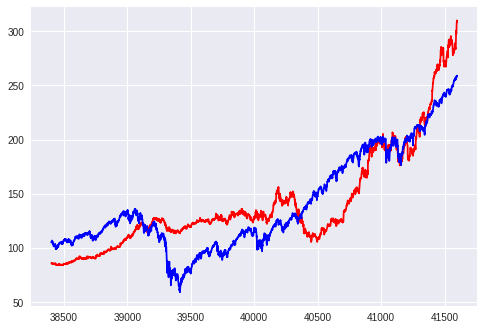

[ 89.72146606  89.53733826  89.31088257 ... 322.46347046 321.95465088
 321.10696411]


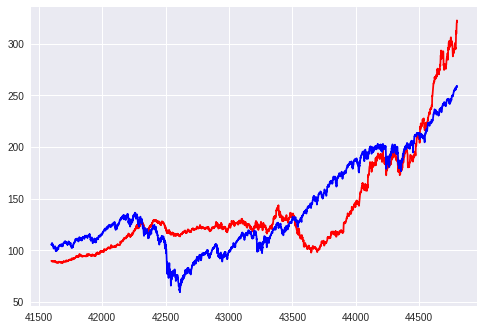

[ 93.00517273  92.92512512  92.73133087 ... 303.5385437  303.06219482
 302.28039551]


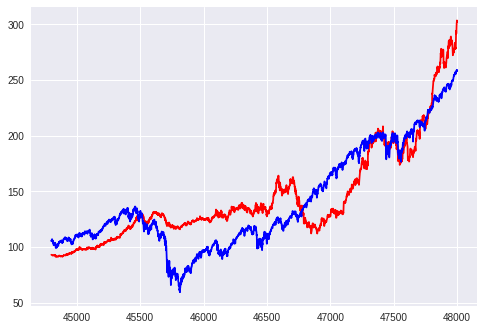

[ 91.03165436  90.87897491  90.68662262 ... 305.82446289 305.34484863
 304.56088257]


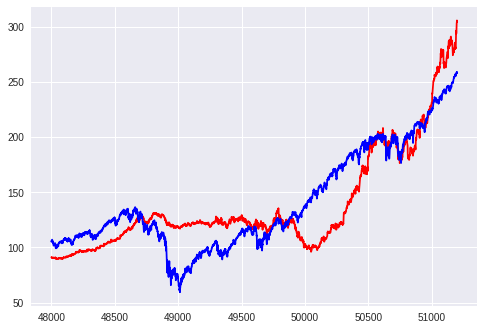

[ 95.15651703  95.11586761  94.94918823 ... 318.08370972 317.58169556
 316.76467896]


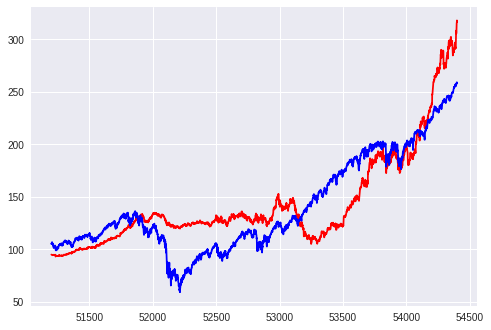

[ 98.0520401   97.93009949  97.765625   ... 314.99093628 314.48770142
 313.68261719]


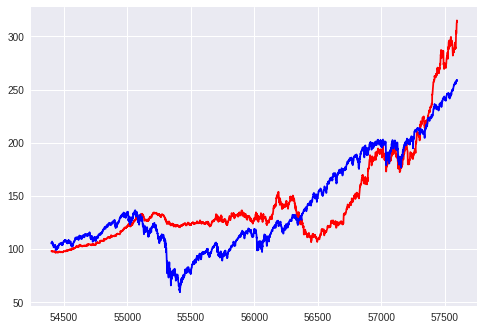

[ 99.02429962  98.95593262  98.8219986  ... 313.57382202 313.07211304
 312.27371216]


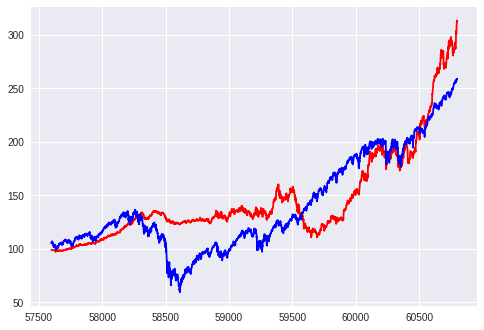

[ 99.72596741  99.65817261  99.54525757 ... 304.94110107 304.45504761
 303.68695068]


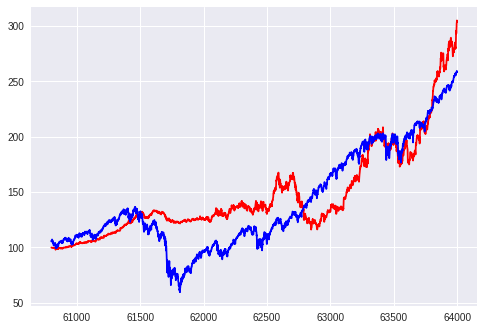

[ 97.56872559  97.57609558  97.5118103  ... 314.85037231 314.34616089
 313.55105591]


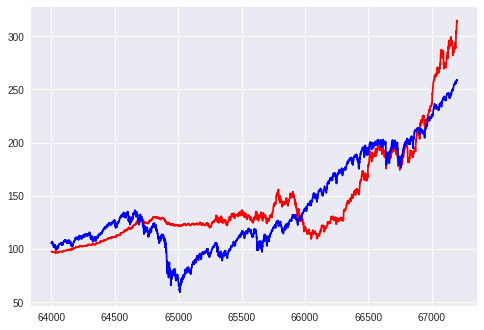

[103.08599854 103.10382843 103.07376099 ... 315.35025024 314.84347534
 314.04711914]


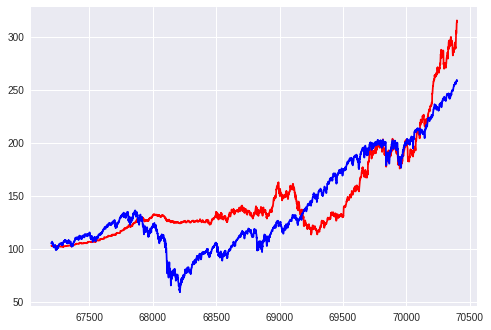

[103.86320496 103.82698822 103.76030731 ... 297.15914917 296.6847229
 295.94308472]


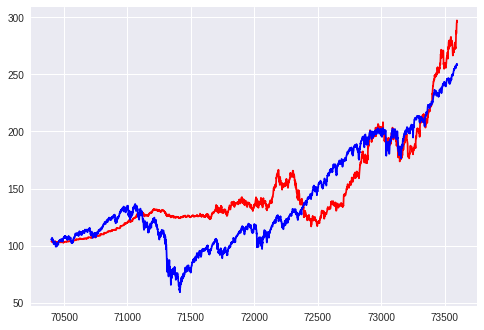

[101.0345993  101.04657745 101.01506042 ... 312.67193604 312.17053223
 311.38775635]


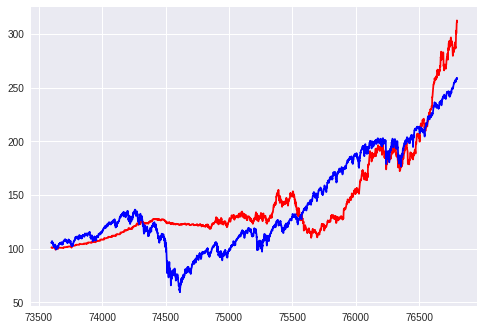

[106.62300873 106.75028229 106.77301788 ... 305.82775879 305.33447266
 304.56845093]


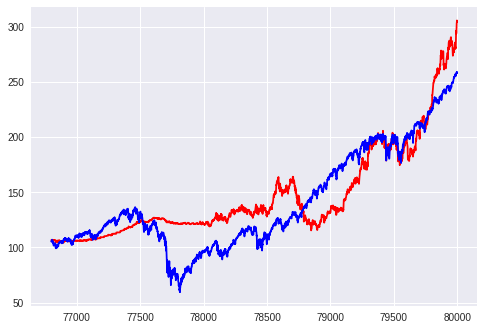

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [22]:
main()